### Imports


In [2]:
import os
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Definition of global constants

In [3]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'images')

In [13]:
BREED_DICT = { # 0 for cat, 1 for dog
    'persian': 0,
    'ragdoll': 0,
    'havanese': 1,
    'sphynx': 0,
    'keeshond': 1,
    'beagle': 1,
    'leonberger': 1,
    'english_cocker_spaniel': 1,
    'german_shorthaired': 1,
    'saint_bernard': 1,
    'japanese_chin': 1,
    'pug': 1,
    'newfoundland': 1,
    'yorkshire_terrier': 1,
    'basset_hound': 1,
    'birman': 0,
    'great_pyrenees': 1,
    'boxer': 1,
    'staffordshire_bull_terrier': 1,
    'wheaten_terrier': 1,
    'egyptian_mau': 0,
    'maine_coon': 0,
    'american_pit_bull_terrier': 1,
    'shiba_inu': 1,
    'miniature_pinscher': 1,
    'samoyed': 1,
    'abyssinian': 0,
    'pomeranian': 1,
    'russian_blue': 0,
    'bombay': 0,
    'english_setter': 1,
    'chihuahua': 1,
    'british_shorthair': 0,
    'siamese': 0,
    'bengal': 0,
    'american_bulldog': 1,
    'scottish_terrier': 1
}



Testing image functionality

We store the labels for each image by creating a dict {'image-name' : [label1, label2, label3]} using list.txt

In [4]:
def create_image_labels(file : str):
    import re
    IMG_LABELS = {}
    IMG_NAMES = []
    pattern = r'^[A-Za-z0-9_]+\s+\d+\s+\d+\s+\d+$'
    # Function to check if a line is valid
    def is_valid_line(line):
        return re.match(pattern, line) is not None

    filename = 'annotations/' + file
    # create dict from list.txt
    with open(filename, 'r') as file:

        # Read each line in the file
        for line in file:
            # use regex
            if is_valid_line(line):
                # Split the line into tokens
                tokens = line.split()
                
                # Extract the image name and attributes
                image_name = tokens[0]
                attributes = [int(token) for token in tokens[1:]]
                IMG_NAMES.append(image_name)
                # Add entry to the dictionary
                IMG_LABELS[image_name] = attributes
    return IMG_LABELS, IMG_NAMES


Lets define the dataset for the binary classification problem

In [24]:
from torchvision.io import ImageReadMode

class CatAndDogsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        self.img_labels = {'Abyssninan101' : [1, 1, 1], ...}
        self.img_names = ['Abyssnian101', ...]
        """
        self.img_labels, self.img_names = create_image_labels(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+'.jpg')
        image = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_labels[img_name]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Creating transforms for images and labels

In [25]:
from torchvision import transforms
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=False),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=False),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

binary_transform = lambda x: x[1]

training_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=train_transform, target_transform=binary_transform)
validation_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=val_transform, target_transform=binary_transform)
# shuffle and split into validation and training
import random

indices = list(range(len(training_data)))
random.seed(310)  # fix the seed so the shuffle will be the same everytime
random.shuffle(indices)
train_size = int(0.8 * len(training_data))
train_dataset_split = torch.utils.data.Subset(training_data, indices[:train_size])
val_dataset_split = torch.utils.data.Subset(validation_data, indices[train_size:])


The result is something like this

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


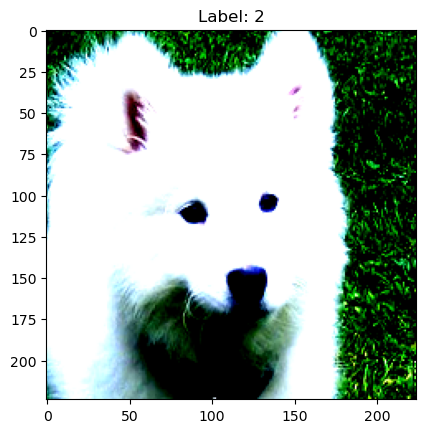

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


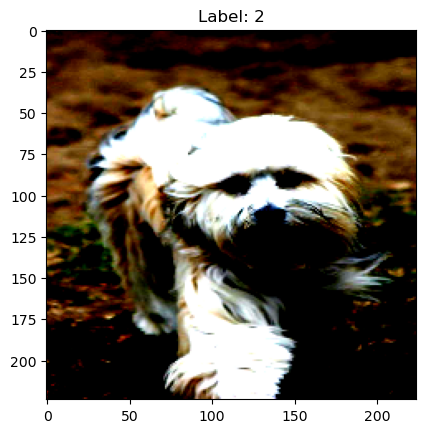

In [7]:
# Display image and label.
def show_image(image, label):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Label: {label}')
    plt.show()

# Get the first image and its label
image, label = train_dataset_split[5]
show_image(image, label)

image, label = val_dataset_split[152]
show_image(image, label)

Time to finetune a model to our needs

First we create our dataloaders

In [8]:
train_dataloader = DataLoader(train_dataset_split, batch_size=64)
val_dataloader = DataLoader(val_dataset_split, batch_size=64)

Next we create the model and change the last layer

In [22]:
# create the resnet18 model and change last layer
from torchvision import models
from torch import nn

model = models.resnet18(weights='DEFAULT')

num_classes = 3

# Freeze all layers except last one
for param in model.parameters():
    param.requires_grad = False

# Change the output layer
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)


Lets define the hyperparameters for training

In [14]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Now we create the optimization loops

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now we train the model

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.568044  [   64/ 2944]


Corrupt JPEG data: premature end of data segment


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0